<h1 style="text-align: center;">
    🎲 Sampling from static distributions
</h1>

This notebook demonstrates how to create distributions from a series of functions using `streamgen`.

First, we will create one background and two class signals using `numpy`.
Then, we will demonstrate how to use the `SamplingTree` class to sample from these distributions.
Finally, we will add `ClassLabelNode`s, which will allow us to sample labeled signals.

---

## 📄 Table of Contents

1. [🧮 Function based data generation](#🧮-function-based-data-generation)
2. [🌳 Sampling trees](#🌳-sampling-trees)
3. [🏷️ Generating labels](#🏷️-generating-labels)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from streamgen.parameter.store import ParameterStore
from streamgen.samplers.tree import SamplingTree
from streamgen.transforms import noop

SEED=42
rng = np.random.default_rng(SEED)

## 🧮 Function based data 

We want to generate a dataset of time series.
This dataset consists of three classes with the following parameters:

1. 🎵 **"background"** - background noise from our measurement equipment
    - ⚙️ `signal_length` - how many measurement points are in our signal 
    - ⚙️ `offset` - signal offset of the background noise 
    - ⚙️ `strength` - signal strength of the background noise 
2. 🪜 **"ramp"** - a slowly climbing ramp signal
    - ⚙️ `height` - height of the ramp 
    - ⚙️ `length` - length of the ramp
3. 🏃 **"step"** - a step signal
    - ⚙️ `length` - length of the step 
    - ⚙️ `kernel_size` - kernel size for a moving average filtering 

In [2]:
def background(signal_, signal_length: int, offset: float, strength: float) -> np.ndarray:  # noqa: D103, ANN001, ARG001
    return rng.normal(offset, strength, signal_length)

def ramp(signal: np.ndarray, height: float, length: int) -> np.ndarray:  # noqa: D103
    ramp_signal = np.zeros(len(signal))
    ramp_start = rng.choice(range(len(signal)-length))
    ramp_signal[ramp_start:ramp_start+length] = np.linspace(0.0, height, length)
    return signal + ramp_signal

def step(signal: np.ndarray, length: int, kernel_size: int) -> np.ndarray:  # noqa: D103
    step_signal = np.zeros(len(signal))
    step_start = rng.choice(range(len(signal)-length))
    step_signal[step_start:step_start+length] = 1.0
    kernel = np.ones(kernel_size) / kernel_size
    step_signal = np.convolve(step_signal, kernel, mode="same")
    return signal + step_signal

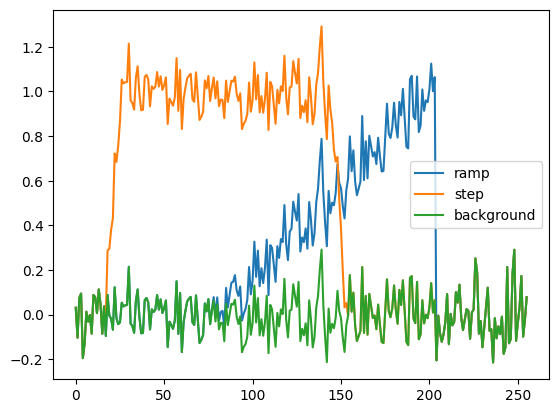

In [3]:
# ⚙️ parameters
signal_length = 256
offset = 0.0
noise_strength = 0.1
height = 1.0
length = 128
kernel_size=10

# 🎲 sample signals
background_sample = background(None, signal_length, offset, noise_strength)
ramp_sample = ramp(background_sample, height, length)
step_sample = step(background_sample, length, kernel_size)

# 📈 plot signals
sns.lineplot(ramp_sample, label="ramp")
sns.lineplot(step_sample, label="step")
sns.lineplot(background_sample, label="background");

## 🌳 Sampling trees

In the last section, we manually sampled from our three signal generation functions.

This approach has a few shortcomings:

+ for each sample, one has to call the corresponding function by hand 🖐️
+ the parameter handling is a bit awkward and clumsy (parameter to function association is not clear)
+ dependencies (like `step` and `ramp` requiring `background` as input) are not clear

To address all of these issues, `streamgen` provides the `SamplingTree` class, which organizes and calls functions very similar to `torchvision.transforms.Compose` or `torch.nn.Sequential`:

```python
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # ...
])

while generating_data:
    sample = np.random.randn(...)
    augmented_sample = transforms(sample)
    # -> sample is passed to the first function in transforms.
    # the output if this transform si then passed as input to the next transform ...
```

Instead of using a sequential organization of functions, `streamgen` uses trees of transformations.

![sampling tree](../../docs/images/sampling_tree.png)

We use the package [anytree](https://anytree.readthedocs.io/en/latest/) and a custom `Node` class (`streamgen.nodes.TransformNode`) to construct these trees.
For convenient construction, we also provide a shorthand description following the rules:

1. Nodes are linked sequentially according to the ordering in the top-level list.
2. `TransformNode` and sub-classes are not modified.
3. `Callable`s are cast into `TransformNode`s.
4. `str` are cast into `ClassLabelNode`
5. dictionaries are interpreted as `BranchingNode`s, where each value represents a branch.
    The keys `name`, `probs` and `seed` are reserved to describe the node itself.
6. If there is a node after a `BranchingNode`, then every branch will be connected to a **copy** of this node.
    This ensures that the structure of the tree is preserved (Otherwise we would create a more generic directed acyclic graph),
    which is not supported by `anytree`.

The parameters of the functions inside a tree are stored in a `ParameterStore` object. A sampling tree knows which parameters need to be passed to the functions based on **scopes**.

> 👉 more details about parameter handling is explained in the next notebook on [🌌 data streams](./02_data_streams.ipynb).

In [4]:
# ⚙️ scoped parameter
params = ParameterStore({
    "background": {
        "signal_length": { "value": 256 },
        "offset": { "value": 0.0 },
        "strength": { "value": 0.1 },
    },
    "ramp": {
        "height": { "value": 1.0 },
        "length": { "value": 128 },
    },
    "step": {
        "length": { "value": 128 },
        "kernel_size": { "value": 10 },
    },
})

# 🎲🌳 tree of transformations
tree = SamplingTree(
    [
        background,
        {
            "background": noop,
            "ramp": ramp,
            "step": step,
        },
    ],
    params,
)

print(tree)

🌳
➡️ `background(offset=0.0, signal_length=256, strength=0.1)`
╰── 🪴 `branching point()`
    ├── ➡️ `noop()`
    ├── ➡️ `ramp(height=1.0, length=128)`
    ╰── ➡️ `step(kernel_size=10, length=128)`



In [ ]:
[
    add_noise,
    resize,
    add_missing_values,
    {
        "class1": [
            add_points,
            "points"
        ],
        "class2": [
            noop,
            "no-pattern"
        ]
    }
]

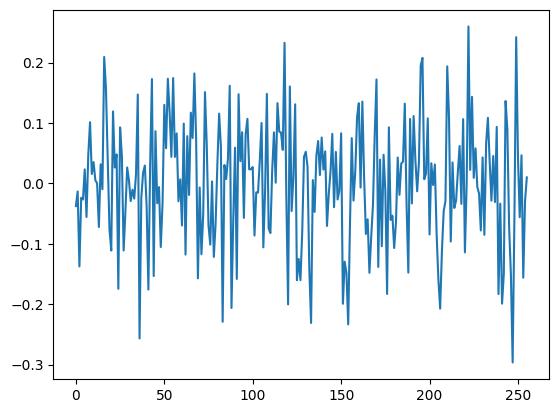

In [5]:
# 🎲 sample from tree
signal = tree.sample()
sns.lineplot(signal);
plt.show()

Output()

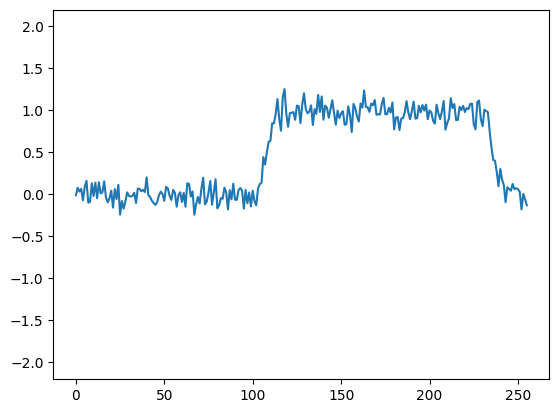

In [6]:
num_samples = 16
samples = tree.collect(num_samples)

def create_frame(idx, ax) -> None:  # noqa: D103, ANN001
    ax.cla()
    signal = samples[idx]
    sns.lineplot(signal, ax=ax).set_ylim(-2.2, 2.2)

fig = plt.figure()
ax = fig.gca()
animation = FuncAnimation(fig, create_frame, frames=num_samples, fargs=(ax,))
HTML(animation.to_jshtml())

## 🏷️ Generating labels

Every path of transformations to a leaf in our sampling tree already corresponds to a "class".

To include the information about the branch into the sample, `streamgen` provides a `ClassLabelNode`, which is automatically created from strings in the tree definition.

In [7]:
# 🎲🌳 tree of transformations
tree = SamplingTree(
    [
        background,
        {
            "background": "background",
            "ramp": [ramp, "ramp"],
            "step": [step, "step"],
        },
    ],
    params,
)

print(tree)

🌳
➡️ `background(offset=0.0, signal_length=256, strength=0.1)`
╰── 🪴 `branching point()`
    ├── 🏷️ `background`
    ├── ➡️ `ramp(height=1.0, length=128)`
    │   ╰── 🏷️ `ramp`
    ╰── ➡️ `step(kernel_size=10, length=128)`
        ╰── 🏷️ `step`



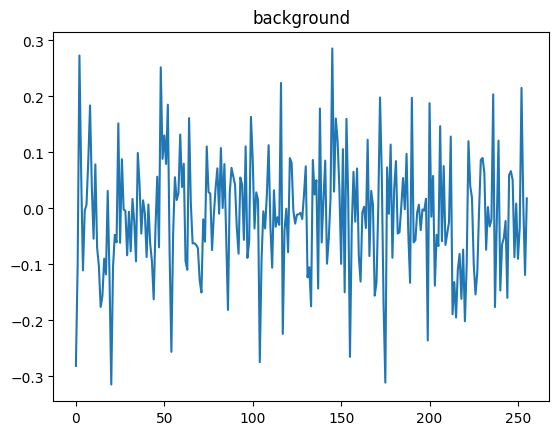

In [8]:
# 🎲 sample from tree
signal, target = tree.sample()
sns.lineplot(signal).set_title(target);